# Удержание клиентов Фитнес-центра

## Описание проекта

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;
    
    2) предложить меры по снижению оттока;
    
    3) определить другие особенности взаимодействия с клиентами.

## Содержание

* [Подготовка данных ](#prepare_date)
* [Вывод по преобратоки данных](#result_pre)
* [Модель прогнозирования](#model)
* [Кластеризация результатов](#class)
* [Выводы](#result)
* [Рекомендации](#recomend)

## <a id = prepare_date> Подготовка данных </a>

### Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from plotly import graph_objects as go

### Чтение файла

In [2]:
try:
    df = pd.read_csv('gym_churn.csv') # Чтение с локальной машины
except:
    df = pd.read_csv('/datasets/gym_churn.csv') # Чтеие с сервера   

In [3]:
df.head()#Верзние 5 значений

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.columns = df.columns.str.lower() # Приводим названия столбцов к нижнему регистру

In [5]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Предобработка и исследовательский анализ данных (EDA) 

Рассмотрим информацию о датасете

Проверим наличие дупликатов

In [6]:
df.duplicated().sum()

0

Информация о датасете:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Поменяем типы данных там, где всего 2 варианта - либо "0" либо "1"

In [8]:
df[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']] = df[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']].astype('bool')

In [9]:
df['month_to_end_contract'].value_counts()

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

Так как количество месяцев до конйа контракта целые числа, поменяем тип данных

In [10]:
df[['month_to_end_contract']] = df[['month_to_end_contract']].astype('int')

In [11]:
df.describe()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


**Данные равномерные, стандартные отклонения не очень далеко от средних, а также не похоже, что есть выбросы.**

### Среднее значение признаков ушедших и оставшихся клиентов

In [12]:
churn_mean = df.groupby('churn').mean()

In [13]:
churn_mean

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
False,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
True,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Просмотрим результаты группировки:
* `gender` - среднее одинаково, это говорит о том, что этот признак не влияет на отток/приток.
* `near_location` - незначительно, но все таки среди пользователей остаются чуть больше людей живущие\рабатающие около зала
* `partner` - скидка партнера все-таки влияет на число оставшихся кли
* `promo_friends` - в целом немного людей остаются после акции "Приведи друга", но все же часть оставшихся людей больше чем ушедших
* `phone` - наличие контактного телефона сейчас обычная практика, так что этот параметр точно никак не может влиять на отток посетителей
* `contract_period` - срок абонимента все таки влияет на посещение спортзала. Чем наольше куплен абонимент, тем маловеростнее от него откажутся
* `group_visits` - групповые занятия, судя по числам, больше привелкают людей к тому, чтобы продолжать заниматься
* `age` - три года разницы - не существенна. Вряд ли стоит говорить о влиянии возраста на отток клиентов
* `avg_additional_charges_total` - неудивительно что постоянные клиенты оставляют больше денег в спортзале, чем те, которые возможно "отвалятся"
* `lifetime` - в среднем человек за месяц посещения спортзала понимает, будет он продолжать заниматься или нет. На это стоит обратить внимание
* `avg_class_frequency_total` - небольшая разница в количесвте посещений зала у двух групп пользователей
* `avg_class_frequency_current_month`- вот здесь уже стоит обратить внимание, возможно предложив клиенту такое занятие, куда бы он приходил 2 раза в неделю - он могбы с большей долей вероятностью остаться

### Гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

Для построения гистограмм и распределений, разобъем фрейм на булевы признаки и нет

In [14]:
bool_features = [] # Пустой список для булевух признаков

not_bool_features = [] # Пустой список для НЕ булевых пизнаков

for col in (df.columns):
    if df[col].dtype == 'bool':
        bool_features.append(col)
    else:
        not_bool_features.append(col)

In [15]:
print("Булевы признаки:",bool_features)

Булевы признаки: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']


In [16]:
print("НЕ булевы признаки:",not_bool_features)

НЕ булевы признаки: ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']


Для построения распределений, уберем из списка булевых признаков значение `churn`

In [17]:
bool_features.remove('churn')

**Распределение БУЛЕВЫХ ПРИЗНАКОВ**

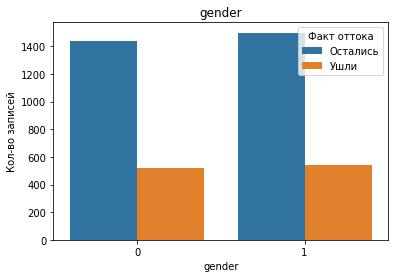

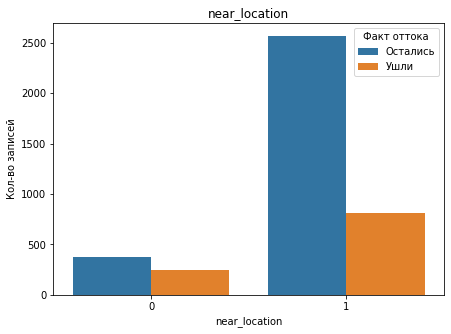

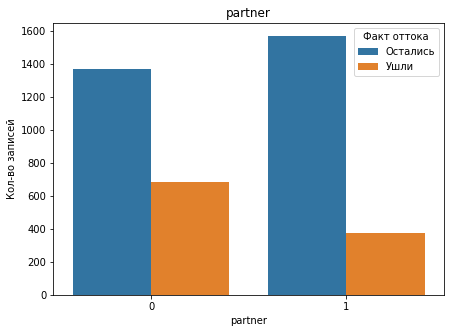

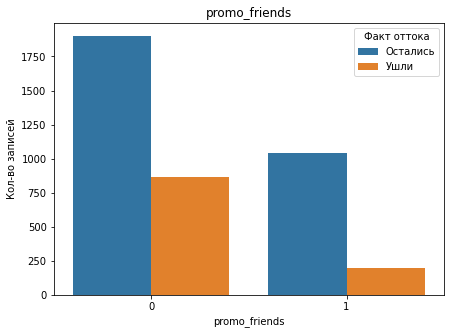

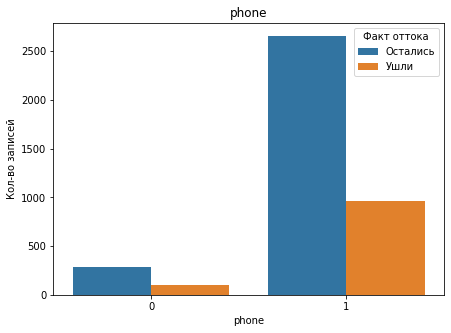

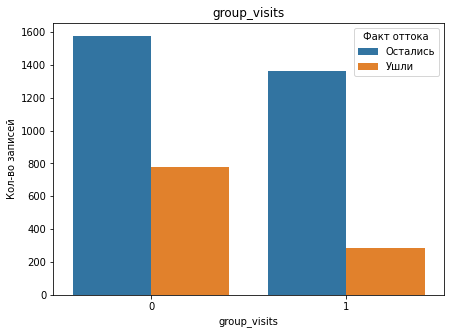

<Figure size 504x360 with 0 Axes>

In [18]:
for features in bool_features:
    fig = sns.countplot(data=df, x = df[features].astype(int), hue = 'churn')
    fig.set_title(features)
    fig.legend(title='Факт оттока', labels=['Остались', 'Ушли'])
    plt.figure(figsize=(7, 5))
    fig.set_ylabel('Кол-во записей');
    

**Вывод**

* `gender` - Доля мужчин и женщин приблизительно одинакова. Как и в числе оставшихся так и в числе ушедших клиентов
* `near_location` - большинство клиентов предпочитают заниматсья около работы/дома. При этом отток клиентов у пользователей, кто занимается не около дома/работы выше.
* `partner` - участники партерских программ более склонны к продолжению занятий по сравнению с другими пользовтелями
* `promo_friends` - среди пользователей, првиеденных друзьями, доля оттока заметно ниже, чем у остальных пользоватлей
* `phone` - по данным этого графика сложно судить, так как сейчас практически везде просят оставить телефон. И данные этого рафика не информативны для исследования
* `group_visit` - среди тех, кто посещает групповые занятия доля оттока меньше

**Распределение НЕ БУЛЕВЫХ ПРИЗНАКОВ**

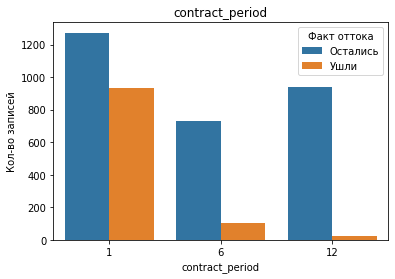

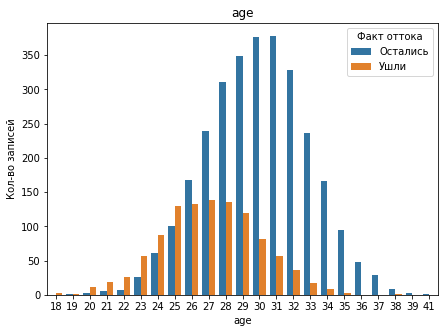

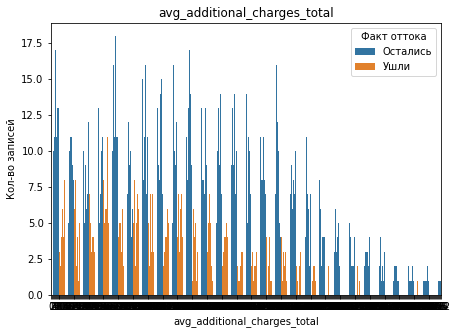

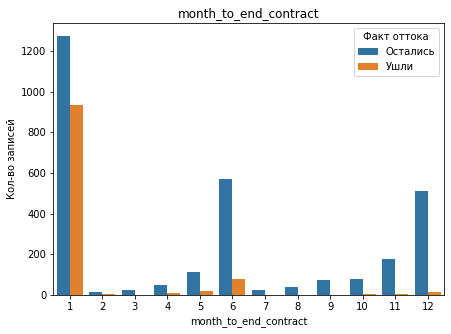

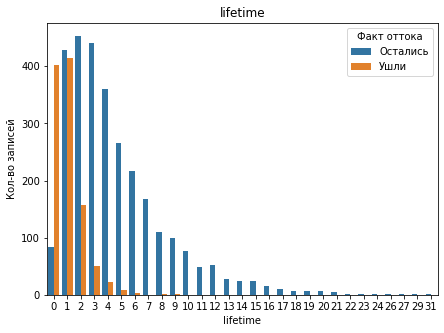

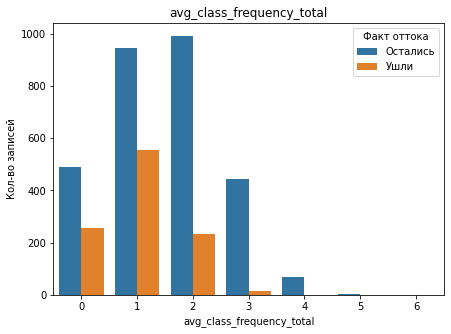

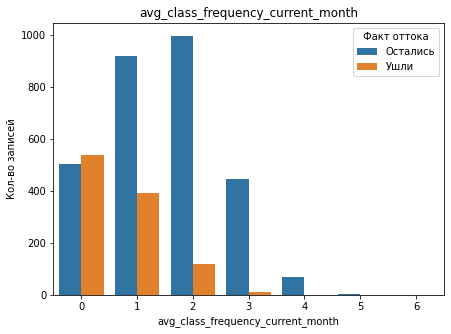

<Figure size 504x360 with 0 Axes>

In [19]:
for features in not_bool_features:
    fig = sns.countplot(data=df, x = df[features].astype(int), hue = 'churn')
    fig.set_title(features)
    fig.legend(title='Факт оттока', loc='upper right', labels=['Остались', 'Ушли'])
    plt.figure(figsize=(7, 5))
    fig.set_ylabel('Кол-во записей');
    

* `contract_period` - чем дольше срок абонимента - тем меньшая доля оттока
* `age` - до 26 лет отток преобладает над оставшимеся пользователями. В 26 наблюдается большая и в последствии растущая заинтерисованность в занятии спортом
* `avg_additional_charges_total` - здесь можно сказать, что доли ушел/остался мало зависят от трат на доп.услуги.
* `month_to_end_contract` - если до окончания контаркта остается один месяц - доля ушедших пользователей очень вилика
* `lifetime` - первые 2 месяца самые показательные, оснавня часть клиентов отваливается в этот промежуток
* `avg_class_frequency_total` - У тех кто ходит до 2 раз в неделю доли оттока примерно одинаковые, но ситуация резко меняется если клиент ходит 3 раза, а если 4-5 раз(это наверно профессиональные спортсмены), то вообще оттока не видно, но таких клиентов значительно меньше.
* `avg_class_frequency_current_month` - чем чаще клиент ходил в клуб за последний месяц, тем и отток меньше

### Матрциа корреляций

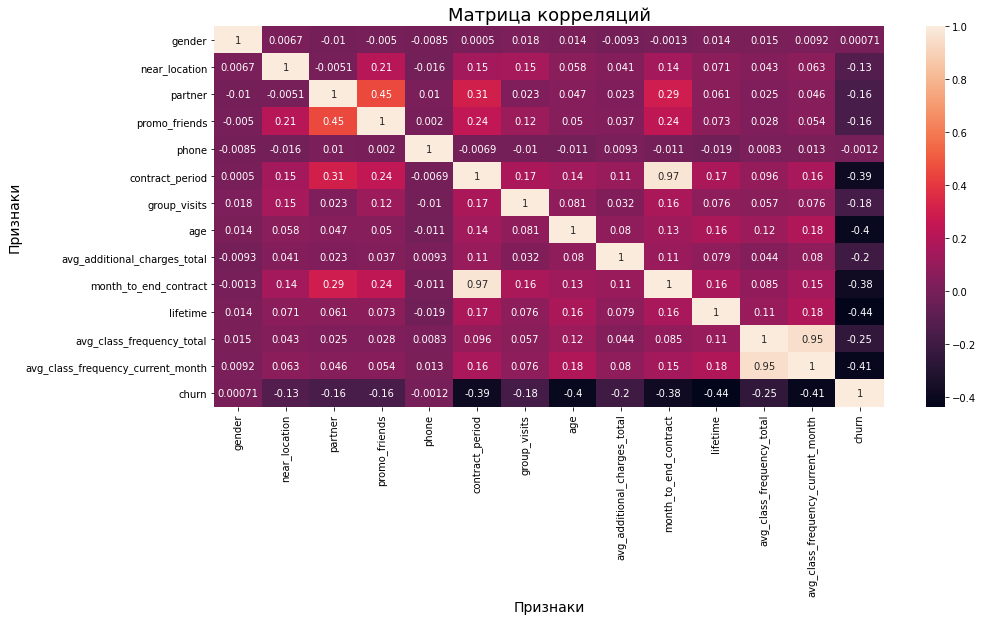

In [20]:
matr_corr = df.corr()
plt.figure(figsize=(15,7))
sns.heatmap(matr_corr, annot = True, square=False)
plt.title('Матрица корреляций', fontsize = 18)
plt.xlabel('Признаки', fontsize = 14) 
plt.ylabel('Признаки', fontsize = 14)
plt.show()

**Вывод**

* `gender` и `phone` - не влияют на отток клиентов (коэффиуиенты корреляции близки к 0)
* `near_location`, `partner`, `promo_friends`, `group_visit`, `avg_additional_charges_total`, `avg_class_frequency_total` - имеют корреляцию ниже среднего (коэффициент корреляции менее 0.3)
* `contract_period`, `age`, `month_to_end_contract`, `lifetime`, `avg_class_frequency_current_month` - наибольшая корреляция из представленных (выше 0.3)

Наибольшая корреляция пар признаков наблюдается:
* `month_to_end_contract` - `contract_period` (0.97)
*  `avg_class_frequency_current_month` - `avg_class_frequency_total` (0.95) 

## <a id=result_pre> Вывод по преобратоки данных </a>

* Записей в фрейме - 4000
* Данные целостные, пропусков и дубликатов нет, сильные выбросы отсутствуют.
* Целевая переменная - отток посетителей. Исходя из данных - почти все приведенные признаки имеют обратную корреляцию с целевой 
* `gender` и `phone` не оказывают влияния на отток посетителей

## <a id = model> Модель прогнозирования </a>

### Разбиение признаков на обучающую и валидационную модели

In [21]:
X = df.drop('churn', axis=1) # Признаки
y = df['churn'] # Целевая функция

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # Рандомное деление данных в отношении 80 на 20

In [23]:
scaler = StandardScaler() # объект класса StandardScaler
X_train_st = scaler.fit_transform(X_train) # Транформируем обучающую выборку
X_test_st = scaler.transform(X_test) # Трансформиеруем валидационную выборку

### Обучение модели

Создадим 2 модели по выборке:
* логистической регрессией
* случайным лесом

In [24]:
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(n_estimators = 100, random_state=0)
]

In [25]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        '-accuracy:{:.2f}\n-precision:{:.2f}\n-recall_score:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )

In [26]:
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0)
-accuracy:0.92
-precision:0.85
-recall_score:0.83 
RandomForestClassifier(random_state=0)
-accuracy:0.92
-precision:0.84
-recall_score:0.81 


**Вывод**

* ***Доля правильных ответов.*** У обоих методов занчение одинаково
* ***Точность.*** Метод логистической регрессии показал себя лучше
* ***Полнота.*** Метод логистической регрессии показал себя лучше

По всем параметрам чуть впереди модель **Линейной регрессии**

## <a id=class>Кластеризация результатов</a>

In [27]:
# стандартизируем данные
sc = StandardScaler() 
x_sc = sc.fit_transform(X)
linked = linkage(x_sc, method = 'ward')

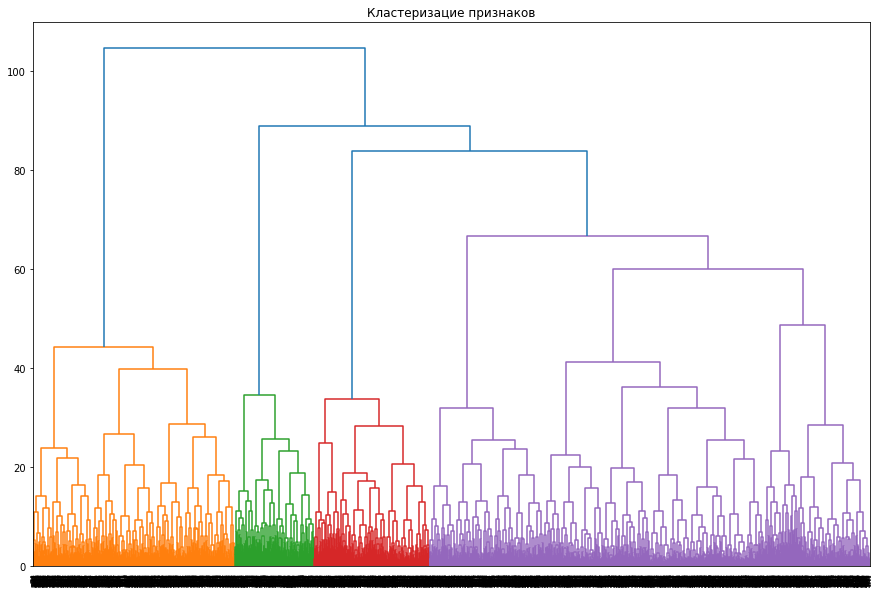

In [28]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризацие признаков')
plt.show() 

Оптимальное число кластеров - это количесвто разедлений по цвету. По нашим данным - **4 кластера**. 

Для дальейшего расчета выбираем число кластеров 5 исходя из эксперементальных данных по разбиению на кластеры

### Кластеризация методом K-means

In [29]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [30]:
df['cluster_km'] = labels #Добавляем расстояние в изначальный датафрейм

In [31]:
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


**Описание полученных кластеров**

***Кластер 0***
* Пользователи живущие около фитнес центра
* Приглашены по партнерской программе
* Преимущественно период контракта 12 месяцев
* В среднем посещают зал 1-2 раза в неделю
* Средний возраст 30 лет
* Слабо подвержены оттоку

***Кластер 1***
* Большинство клиентов живет около фитнес центра
* Средне пользуются партнерской программой
* Купили абонимент в основном на 6 месяцев
* Средний возраст 29 лет
* Подвержены оттоку

***Кластер 2***
* Все живут далеко фитнес центра
* Преимущественно период контракта 1 месяц
* Не используют почти промокоды друзей и партнерскую программу
* Средний возраст 28 лет
* Подвержены оттоку

***Кластер 3***
* Все живут около фитнес центра
* В большенстве не используют партнерскую программу
* Возраст 28 лет
* Абонимент на 1 месяц в основном
* Наиболее подержены оттоку

***Кластер 4***
* Большенство живет около фитнес центра
* Покупают абонимент на 1-6 месяцев
* Возраст 30 лет
* Посещают зал 2-3раза в неделю
* не подвержены оттоку

### Распределение признаков по кластерам

Распределение по Булевым признакам

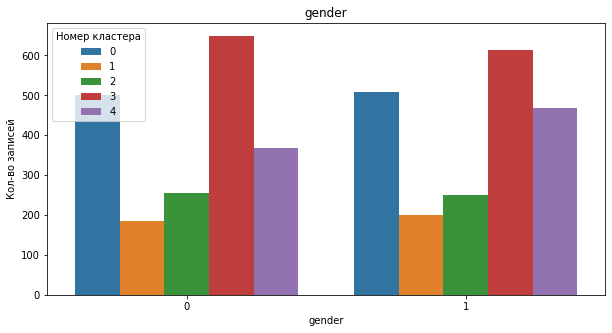

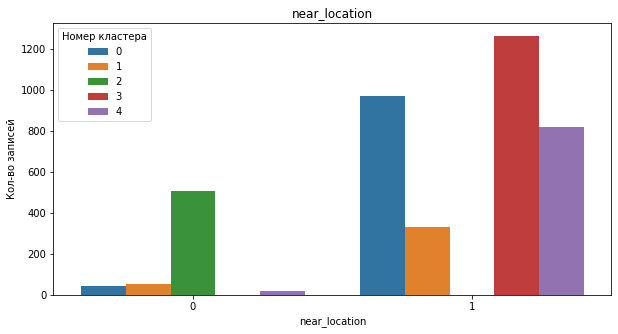

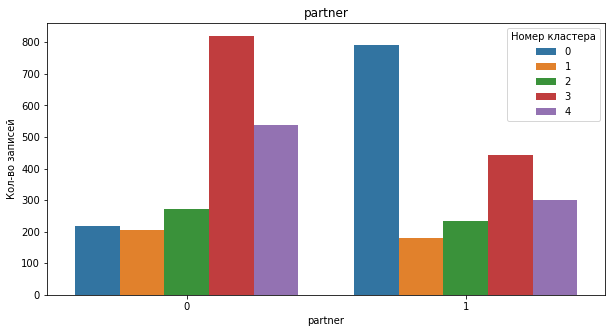

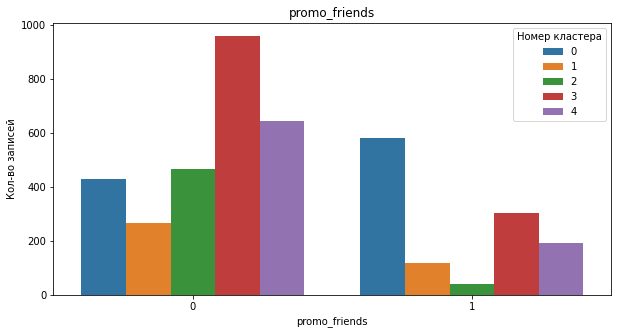

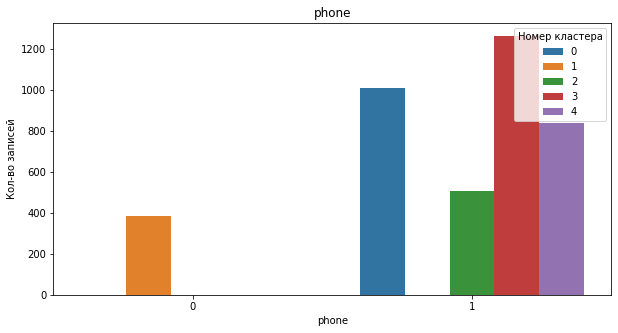

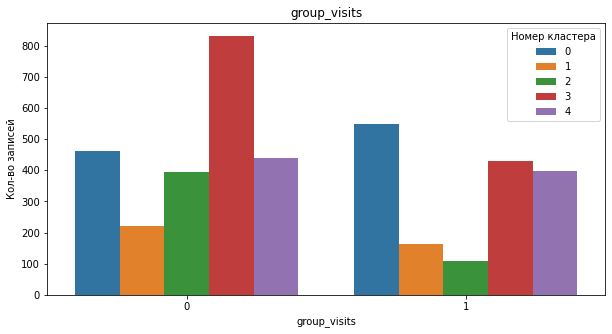

In [32]:
for features in bool_features:
    plt.figure(figsize=(10, 5))
    fig = sns.countplot(data=df, x = df[features].astype(int), hue = 'cluster_km')
    fig.set_title(features)
    fig.legend(title='Номер кластера')
    fig.set_ylabel('Кол-во записей');

<Figure size 720x360 with 0 Axes>

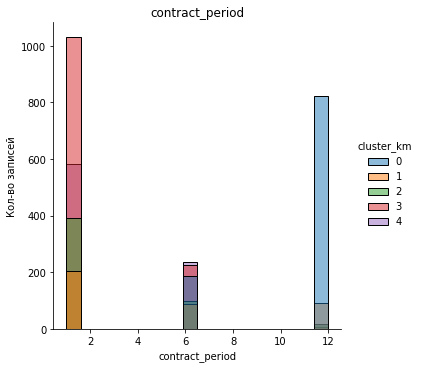

<Figure size 720x360 with 0 Axes>

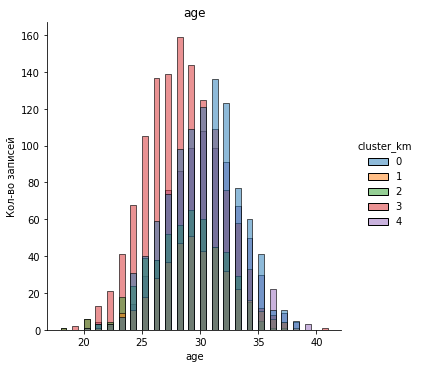

<Figure size 720x360 with 0 Axes>

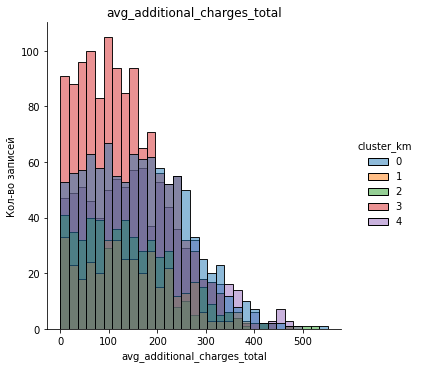

<Figure size 720x360 with 0 Axes>

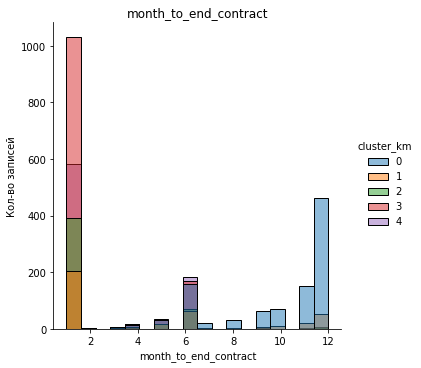

<Figure size 720x360 with 0 Axes>

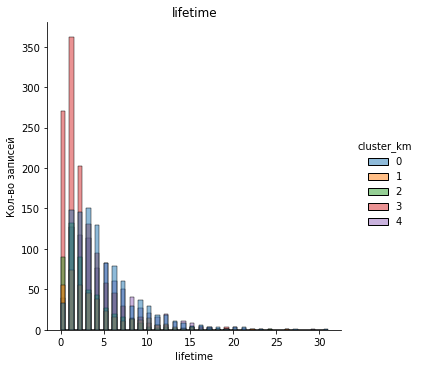

<Figure size 720x360 with 0 Axes>

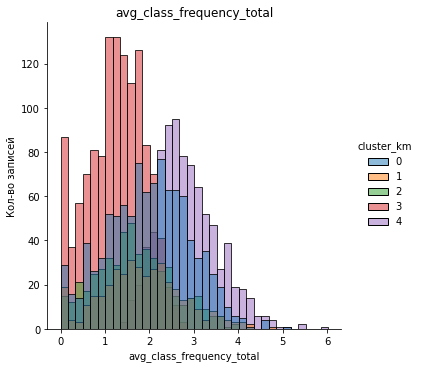

<Figure size 720x360 with 0 Axes>

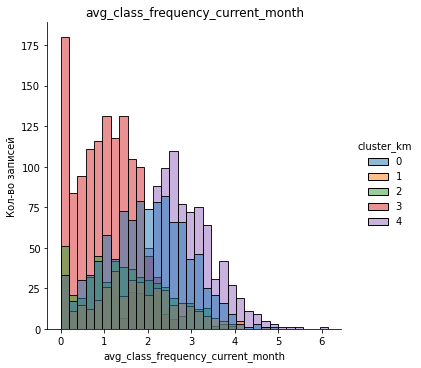

In [33]:
for features in not_bool_features:
    plt.figure(figsize=(10, 5))
    fig = sns.displot(df, x=df[features], hue='cluster_km', palette="tab10", kind='hist')
    plt.title(features)
    plt.ylabel('Кол-во записей');

**Вывод**

Все представленные гафики подтверждают результаты, полученные при расчете средних показателей по кластерам 

### Доля оттока по кластерам

In [34]:
df_churn = df.query('churn==1').groupby('cluster_km')['churn'].count() / df.groupby('cluster_km')['churn'].count()
df_churn

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64

In [37]:
df_churn_1 = df.groupby('cluster_km')['churn'].mean() #Для себя, чтобы проверить правильность расчета 
df_churn_1

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64

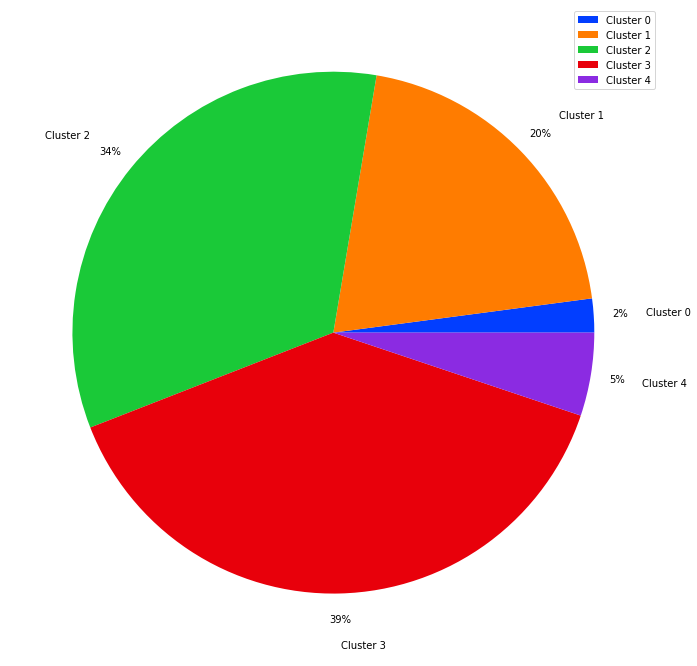

In [35]:
colors = sns.color_palette('bright')[0:5]
plt.figure(figsize = (12,12))
labels = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4']
plt.pie(df_churn, labels = labels, colors = colors, autopct='%.0f%%',  pctdistance=1.1, labeldistance=1.2)
plt.legend(loc='upper right')
plt.show()

Нибольшая доля оттока у 3ого Кластера. Напомним его описание:

***Кластер 3***
* Все живут около фитнес центра
* В большенстве не используют партнерскую программу
* Возраст 28 лет
* Абонимент на 1 месяц в основном
* Наиболее подержены оттоку

## <a id =result>Выводы</a>

**По общим данным**

Описание профиля пользователей по признакам

* `gender` - Доля мужчин и женщин приблизительно одинакова. Как и в числе оставшихся так и в числе ушедших клиентов
* `near_location` - большинство клиентов предпочитают заниматсья около работы/дома. При этом отток клиентов у пользователей, кто занимается не около дома/работы выше.
* `partner` - участники партерских программ более склонны к продолжению занятий по сравнению с другими пользовтелями
* `promo_friends` - среди пользователей, првиеденных друзьями, доля оттока заметно ниже, чем у остальных пользоватлей
* `phone` - по данным этого графика сложно судить, так как сейчас практически везде просят оставить телефон. И данные этого рафика не информативны для исследования
* `group_visit` - среди тех, кто посещает групповые занятия доля оттока меньше
* `contract_period` - чем дольше срок абонимента - тем меньшая доля оттока
* `age` - до 26 лет отток преобладает над оставшимеся пользователями. В 26 наблюдается большая и в последствии растущая заинтерисованность в занятии спортом
* `avg_additional_charges_total` - здесь можно сказать, что доли ушел/остался мало зависят от трат на доп.услуги.
* `month_to_end_contract` - если до окончания контаркта остается один месяц - доля ушедших пользователей очень вилика
* `lifetime` - первые 2 месяца самые показательные, оснавня часть клиентов отваливается в этот промежуток
* `avg_class_frequency_total` - У тех кто ходит до 2 раз в неделю доли оттока примерно одинаковые, но ситуация резко меняется если клиент ходит 3 раза, а если 4-5 раз(это наверно профессиональные спортсмены), то вообще оттока не видно, но таких клиентов значительно меньше.
* `avg_class_frequency_current_month` - чем чаще клиент ходил в клуб за последний месяц, тем и отток меньше

Матрйиа корреляции по отношению к целевой функции показала следующий результат:
* `gender` и `phone` - не влияют на отток клиентов (коэффиуиенты корреляции близки к 0)
* `near_location`, `partner`, `promo_friends`, `group_visit`, `avg_additional_charges_total`, `avg_class_frequency_total` - имеют корреляцию ниже среднего (коэффициент корреляции менее 0.3)
* `contract_period`, `age`, `month_to_end_contract`, `lifetime`, `avg_class_frequency_current_month` - наибольшая корреляция из представленных (выше 0.3)

**По модели прогнозирования**

Целевая функция - отток клиентов. Сравнение 2х моделей - логичсекой регрессии и случайным лесом.
* ***Доля правильных ответов.*** У обоих методов занчение одинаково
* ***Точность.*** Метод логистической регрессии показал себя лучше
* ***Полнота.*** Метод логистической регрессии показал себя лучше

По всем параметрам чуть впереди модель **Линейной регрессии**

**Кластеризация**

По матрице расстояний получено число кластеров равное **5**.

По заданному в результате числу кластеров проведено обучение модели кластеризации на основании алгоритма K-Means и спрогнозированы кластеры клиентов.
Получено описание кластеров:

***Кластер 0***
* Пользователи живущие около фитнес центра
* Приглашены по партнерской программе
* Преимущественно период контракта 12 месяцев
* В среднем посещают зал 1-2 раза в неделю
* Средний возраст 30 лет
* Слабо подвержены оттоку

***Кластер 1***
* Большинство клиентов живет около фитнес центра
* Средне пользуются партнерской программой
* Купили абонимент в основном на 6 месяцев
* Средний возраст 29 лет
* Подвержены оттоку

***Кластер 2***
* Все живут далеко фитнес центра
* Преимущественно период контракта 1 месяц
* Не используют почти промокоды друзей и партнерскую программу
* Средний возраст 28 лет
* Подвержены оттоку

***Кластер 3***
* Все живут около фитнес центра
* В большенстве не используют партнерскую программу
* Возраст 28 лет
* Абонимент на 1 месяц в основном
* Наиболее подержены оттоку

***Кластер 4***
* Большенство живет около фитнес центра
* Покупают абонимент на 1-6 месяцев
* Возраст 30 лет
* Посещают зал 2-3раза в неделю
* не подвержены оттоку

**Результат кластеризации и поиска максимального оттока**

Масмиальная доля оттока пользователей у Кластера номер 3

## <a id=recomend> Рекомендации </a>

* Предлагать клиентам контракты на более продолжительный срок (путем применения специальных предложений)
* Предлагать для клентов моложе 30 лет больше промоакций и партнерских программ
* Прделагать занятия\атмосферу в фитнес центре, которая будет привлекательна для занятий (2-3 раза в неделю)
* Целевая аудитория:
    * Посетители 30 лет
    * работающие\живущие около фитнес центров